In [40]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

We inject a tone with known frequency $\nu$. If the sampling rate of the ADC $f_s^{\rm ADC}$ differs from the desired (master) sampling rate $f_s$, there will be a phase difference:

$$V(t) = e^{i2\pi\nu t},\, V_{\rm ADC}(t) = e^{i2\pi\nu t_{\rm ADC}} \\
e^{i \Delta \phi} = V_{\rm ADC}V^* = e^{i2\pi\nu (t_{\rm ADC}-t)} \\
\Delta \phi = 2\pi\nu (t_{\rm ADC}-t) = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right)$$

Thus, if we measure the phase difference, we can recover the sampling rate of the ADC:
$$\frac{f_s}{f_s^{\rm ADC}} - 1 = \frac{\Delta \phi}{2\pi\nu t} \\
f_s^{\rm ADC} = f_s \frac{2\pi\nu t}{\Delta \phi + 2\pi\nu t}$$

Note that $\Delta \phi$ by defintion is between $-\pi$ and $\pi$, so we need to unwrap (i.e. add multiples of $2\pi$ using ``np.unwrap``) before applying the formula above.

<IPython.core.display.Javascript object>


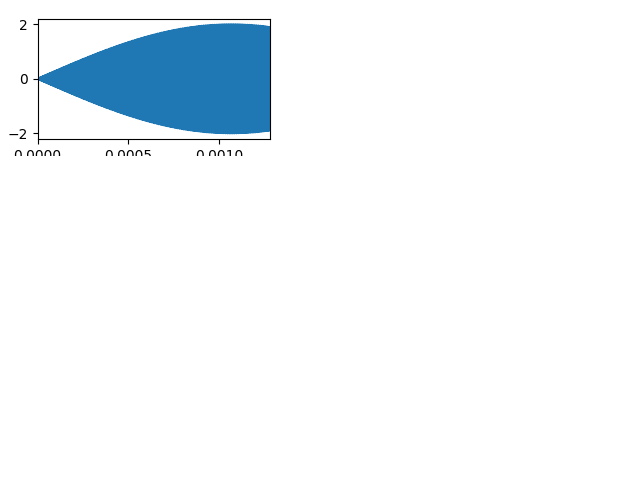

In [46]:
NSAMPLES = 4096
TONE = 901.5e6
LO = 901e6
SAMPLE_RATE = 3.2e6
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega_t = 2 * np.pi * (TONE - LO) * t
tone_cos = np.cos(omega_t)
tone_sin = -np.sin(omega_t)  # conjugate

sample_fq = 3.197e6 # MHz
re = np.cos(omega_t * SAMPLE_RATE / sample_fq)
im = np.sin(omega_t * SAMPLE_RATE / sample_fq)
data = np.array([re, im]).T
data = np.expand_dims(data, axis=0)  # add block axis (with nblocks=1)

plt.figure()
plt.plot(t, tone_cos-re)
plt.xlim(t.min(), t.max())
plt.show()

In [47]:
data = data - np.mean(data, axis=1, keepdims=True)  # remove DC offset
data_cos = data[0,...,0] * tone_cos - data[0,...,1] * tone_sin  # real part (real*real - im*im)
data_sin = data[0,...,0] * tone_sin + data[0,...,1] * tone_cos  # imaginary (real*im + im*real)
dphi = np.arctan2(data_sin, data_cos)  # phase difference in units of radians
# dt = dphi / (2 * np.pi * (TONE - LO))  # phase difference in units of seconds
# dsamp = dt * SAMPLE_RATE  # phase difference in units of sample number

# recover the ADC sample rate
sample_ADC = omega_t / (np.unwrap(dphi) + omega_t) * SAMPLE_RATE
sample_ADC = np.mean(sample_ADC[1:])  # the 0th element is 0 since t = 0 (singularity in the equation above)
print(sample_ADC / sample_fq)  # how close we are to the true ADC sampling rate

0.9999999839915538


In [48]:
from scipy.signal import get_window

RES = 0.001
DTYPE = np.float32
ndt = np.concatenate([np.array([0], dtype=DTYPE), np.arange(1, 0, -RES, dtype=DTYPE)])

_cache = {}

def _clear_cache():
    global _cache
    _cache = {}
    
def _cache_filter(window, half_width, dtype):
    key = (window, half_width)
    if not key in _cache:
        x = np.arange(-half_width, half_width+1, dtype=dtype)
        win = get_window(window, 2*half_width+1).astype(dtype)
        sinc = win[:,None] * np.sinc(x[:,None] - ndt[None,:])
        _cache[key] = sinc
    return _cache[key]
    
def _cache_ker(nsamples, f_in, f_out, dt0, window, half_width, dtype):
    key = (nsamples, f_in, f_out, dt0, window, half_width)
    if not key in _cache:
        x = np.arange(-half_width, half_width+1, dtype=int)
        i = np.arange(nsamples, dtype=int)
        dt = 1 - f_in / f_out
        dt = np.arange(dt0, dt0+nsamples*dt, dt, dtype=dtype)
        off = np.ceil(dt).astype(int)
        dt -= off
        i -= off
        inds = (x[:,None] + i[None,:]).clip(0, nsamples-1)
        sinc = _cache_filter(window, half_width, dtype)
        ker = sinc[:, np.around(dt / RES).astype(int)]
        _cache[key] = inds, ker
    return _cache[key]

def resample(sig_in, f_in, f_out, dt0=0, window='nuttall', half_width=128, dtype=np.float32):
    inds, ker = _cache_ker(sig_in.shape[0], f_in, f_out, dt0, window, half_width, dtype)
    #ker[inds < 0] = 0  # boundary is messed up anyway
    #ker[inds >= nsamples] = 0  # boundary is messed up anyway
    return np.einsum('ij,ij->j', sig_in[inds], ker)
    #return np.sum(sig_in[inds] * ker, axis=0)  # just slightly slower than einsum

<IPython.core.display.Javascript object>


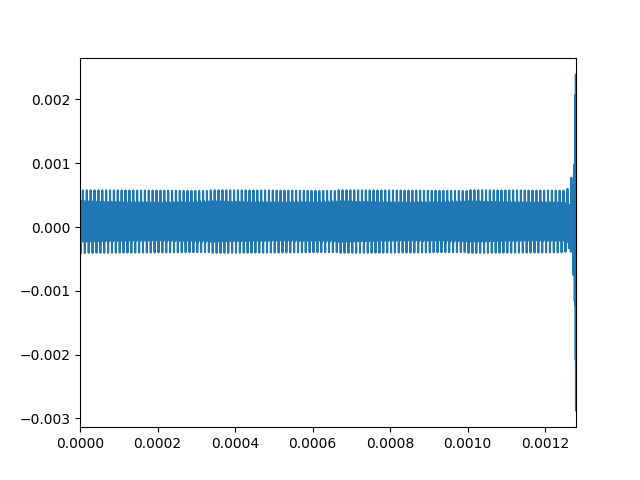

In [49]:
data_rs = resample(data[0, :, 0], sample_ADC, SAMPLE_RATE)

plt.figure()
plt.plot(t, tone_cos - data_rs)
plt.xlim(t.min(), t.max())
plt.show()